In [3]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
sparkmagic 0.20.4 requires nest-asyncio==1.5.5, but you have nest-asyncio 1.5.6 which is incompatible.
  Using cached sagemaker-2.168.0-py2.py3-none-any.whl
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
  Using cached urllib3-1.26.16-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.6.0
    Uninstalling importlib-metadata-6.6.0:
      Successfully uninstalled importlib-metadata-6.6.0
  Attempting uninstall: sagemaker
    Found exist

In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

In [5]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

A Jupyter Widget

In [6]:
# from a dropsown list above we choose model-txt2img-stabilityai-stable-diffusion-v2-1-base

In [7]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

In [8]:
print(model_id)

model-txt2img-stabilityai-stable-diffusion-v2-1-base


In [15]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-abuzar-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type='ml.g5.2xlarge',
)

In [16]:
model_uri = 's3://sagemaker-zara-blouses-generation/loading_dataset/model/model.tar.gz'

In [17]:
# To increase the maximum response size (in bytes) from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# Deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type='ml.g4dn.xlarge',
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

----------!

In [18]:
print(endpoint_name)

jumpstart-example-infer-abuzar-model-tx-2023-06-29-11-29-14-129


In [ ]:
print(

In [17]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

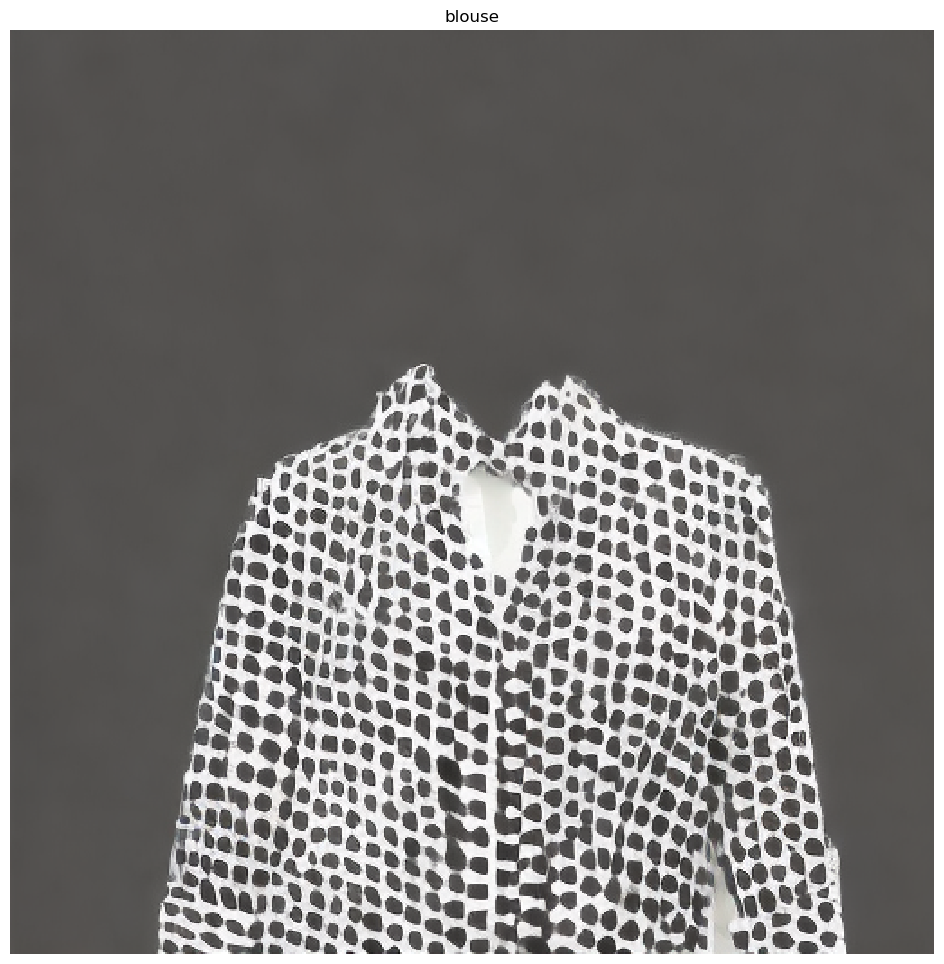

In [21]:
text = "blouse"
query_response = query(model_predictor, text)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### Advanced features

***
This model also supports many advanced parameters while performing inference. They include:

* **prompt**: prompt to guide the image generation. Must be specified and can be a string or a list of strings.
* **width**: width of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **height**: height of the hallucinated image. If specified, it must be a positive integer divisible by 8.
* **num_inference_steps**: number of denoising steps during image generation. More steps lead to higher quality image. If specified, it must a positive integer.
* **guidance_scale**: higher guidance scale results in image closely related to the prompt, at the expense of image quality. If specified, it must be a float. guidance_scale<=1 is ignored.
* **negative_prompt**: guide image generation against this prompt. If specified, it must be a string or a list of strings and used with guidance_scale. If guidance_scale is disabled, this is also disabled. Moreover, if prompt is a list of strings then negative_prompt must also be a list of strings. 
* **num_images_per_prompt**: number of images returned per prompt. If specified it must be a positive integer. Generating multiple images may cause memory issues. Thus, we recommend reducing low height and width if setting num_images_per_prompt>1.
* **seed**: fix the randomized state for reproducibility. If specified, it must be an integer.

***

In [23]:
def display_image(img, prmpt):
    plt.figure(figsize=(12,12))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title(prmpt)
    plt.show()


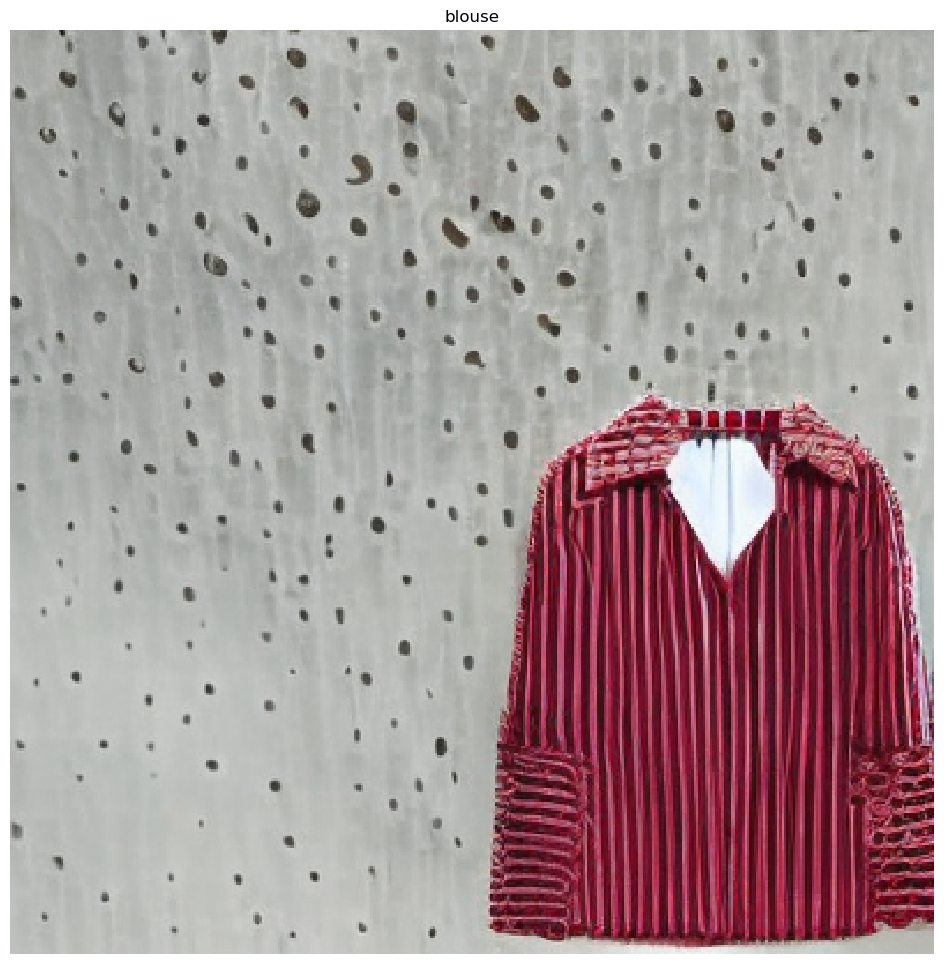

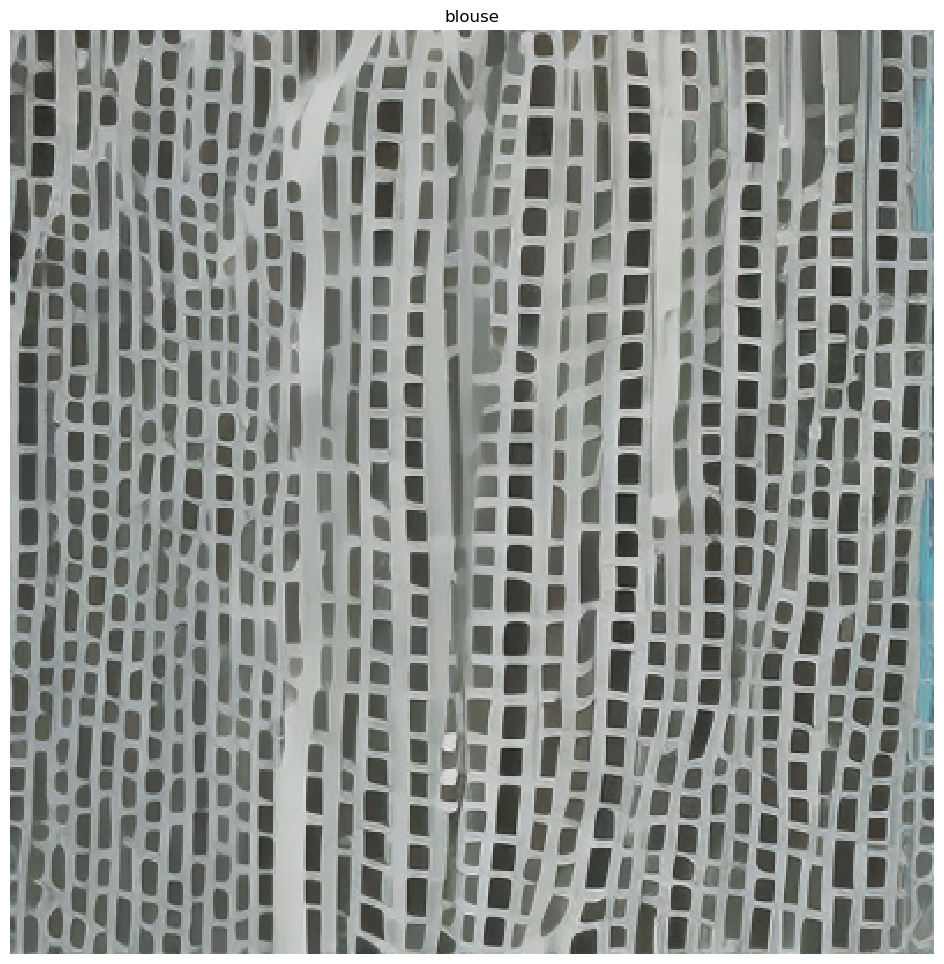

In [24]:
import json
payload = { "prompt":"blouse", "width":400, "height":400,
           "num_images_per_prompt":2, "num_inference_steps":50, "guidance_scale":7.5}


def query_endpoint_with_json_payload(encoded_json):
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=encoded_json)
    return response

def parse_response_multiple_images(query_response):
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['generated_images'], response_dict['prompt']

query_response = query_endpoint_with_json_payload(json.dumps(payload).encode('utf-8'))
generated_images, prompt = parse_response_multiple_images(query_response)
for img in generated_images:
    display_image(img, prompt)

In [13]:
import os
import io
import boto3
import json
import csv

payload = { "prompt":"blouse", "width":400, "height":400,
           "num_images_per_prompt":2, "num_inference_steps":50, "guidance_scale":7.5}


# grab environment variables
ENDPOINT_NAME = 'jumpstart-example-infer-model-txt2img-s-2023-06-29-09-46-00-359' #os.environ['ENDPOINT_NAME']
runtime = boto3.client('runtime.sagemaker')

def lambda_handler(event, context):
    print("Received event: " + json.dumps(event, indent=2))
    
    encoded_json = json.dumps(event).encode('utf-8')
    response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=encoded_json)
    print(response)
    
    response_dict = json.loads(response['Body'].read())
    generated_images, prompt = response_dict['generated_images'], response_dict['prompt']
    

#     for img in generated_images:        
#         display_image(img, prompt)
    return generated_images, prompt


In [14]:
lambda_handler(payload,'')

Received event: {
  "prompt": "blouse",
  "width": 400,
  "height": 400,
  "num_images_per_prompt": 2,
  "num_inference_steps": 50,
  "guidance_scale": 7.5
}


ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint jumpstart-example-infer-model-txt2img-s-2023-06-29-11-17-47-106 of account 567821811420 not found.

In [ ]:
# Delete the SageMaker endpoint
# model_predictor.delete_model()
# model_predictor.delete_endpoint()